# Convex Optimization for Machine Learning & Computer Vision
## Week 8 Programming Exercise - Image Denoising By Line Search
| Name  | Matriculation Number  | E-mail  |
| :------- | :----------------------- | :--------- |
| Akbar, Uzair   | 03697290 | [uzair.akbar@tum.de](mailto:uzair.akbar@tum.de) |

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as splinalg
import matplotlib.pyplot as plt
from PIL import Image

## Read image

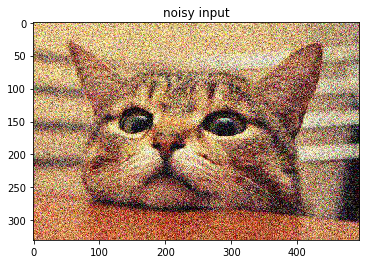

In [2]:
f = np.array(Image.open('cat_noisy.jpg'), dtype=np.float64) / 255
ny, nx, c = f.shape
plt.figure('noisy input')
plt.imshow(f)
plt.title('noisy input')
plt.show()

## TODO: vectorization and construct the linear operator for 3 channels

In [3]:
e_1 = np.ones(nx)
e0 = -np.ones(nx)
e0[-1] = 0
Dx_tilde = sparse.spdiags([e_1, e0], [-1, 0], nx, nx)
e1 = np.ones(ny)
e0 = -np.ones(ny)
e0[-1] = 0
Dy_tilde = sparse.spdiags([e0, e1], [0, 1], ny, ny)

Dx = sparse.kron(Dx_tilde.T, sparse.eye(ny))
Dy = sparse.kron(sparse.eye(nx), Dy_tilde)

K = sparse.vstack([sparse.kron(sparse.eye(c), Dx),
                   sparse.kron(sparse.eye(c), Dy)])

In [4]:
# initialize the variable and parameters
u = f.T.flatten().copy()
max_iters = 100

# huber parameter
epsilon = 0.1

# weight for regularizor
rho = 50

# arrays to record the energy
energy = []
norm_gradient = []

# parameters for line search
c1 = 0.001
c2 = 0.02

alpha_max = 100
alpha0 = 0

## TODO: Implement line search and record the energy, norm of gradient.

In [5]:
def J(u):
    """ denoising objective function J """
    # huber function
    if np.sqrt(np.square(K * u).sum()) <= epsilon:
        J = np.square( K * u ).sum() / (2.*epsilon)
    else:
        J = np.sqrt(np.square( K * u ).sum()) - epsilon/2.
    
    J *= rho
    J += np.square( u - f.T.flatten() ).sum() / 2.
    return J

def nablaJ(u):
    """ gradient of J(.) at u """
    # gradient of huber function
    if np.sqrt(np.square(K * u).sum()) <= epsilon:
        grad = K.T * K * u / epsilon
    else:
        grad = K.T * K * u / np.sqrt(np.square(K * u).sum())
    
    grad *= rho
    grad += u - f.T.flatten()
    return grad

def phi(a):
    """ objective function after step-size a """
    return J(u - a * nablaJ(u))

def phi_(a):
    """ gradient of phi(.) at a """
    return - nablaJ(u - a * nablaJ(u)) @ nablaJ(u)

def zoom(a_lo, a_hi):
    """
    the zoom function for line-search
    reference: http://www.apmath.spbu.ru/cnsa/pdf/monograf/Numerical_Optimization2006.pdf#page=79
    """
    a_j = a_lo
    for _ in range(max_iters):
        a_j = ( a_lo + a_hi )/2.    # bisection
        if phi(a_j) >= phi(a_lo):
            a_hi = a_j
        else:
            if np.abs( phi_(a_j) ) <= -c2 * phi_(0.):
                return a_j
            if phi_(a_j) * (a_hi - a_lo) >= 0.:
                a_hi = a_lo
            a_lo = a_j
    return a_j

def lineSearch():
    """
    the line-search algorithm
    reference: http://www.apmath.spbu.ru/cnsa/pdf/monograf/Numerical_Optimization2006.pdf#page=79
    """
    a = np.zeros(max_iters)
    a = alpha0
    a_ = (a + alpha_max)/2.
    for _ in range(max_iters):
        if phi( a_ ) > phi( a ):
            return zoom( a, a_ )
        if np.abs(phi_( a_ )) <= -c2 * phi_(0.):
            return a_
        if phi_( a_ ) >= 0.:
            return zoom( a_, a )
        a = a_
        a_ = (a_ + alpha_max)/2.
    return a_

# gradient descent with line-search
for i in range(max_iters):
    energy.append( np.square( u - f.T.flatten() ).sum() )
    norm_gradient.append( np.sqrt(np.square( nablaJ(u) )).sum() )
    
    a = lineSearch()         # find step-size
    u = u - a * nablaJ(u)    # gradient descent
    
    print('iteration: {0:d}, energy: {1:.4e}, norm of gradient: {2:.4e}'.format(i, energy[-1], norm_gradient[-1]))
    
    # stopping condition
    if norm_gradient[-1] < 10**-1:
        break

iteration: 0, energy: 0.0000e+00, norm of gradient: 6.0710e+04
iteration: 1, energy: 3.3912e+03, norm of gradient: 3.1201e+04
iteration: 2, energy: 3.6911e+03, norm of gradient: 1.8757e+04
iteration: 3, energy: 4.7200e+03, norm of gradient: 1.4223e+04
iteration: 4, energy: 4.9698e+03, norm of gradient: 9.5623e+03
iteration: 5, energy: 5.4045e+03, norm of gradient: 7.9756e+03
iteration: 6, energy: 5.5365e+03, norm of gradient: 5.4189e+03
iteration: 7, energy: 5.7525e+03, norm of gradient: 4.6199e+03
iteration: 8, energy: 5.8343e+03, norm of gradient: 3.3390e+03
iteration: 9, energy: 5.9501e+03, norm of gradient: 2.8239e+03
iteration: 10, energy: 6.0003e+03, norm of gradient: 2.0817e+03
iteration: 11, energy: 6.0682e+03, norm of gradient: 1.7800e+03
iteration: 12, energy: 6.1002e+03, norm of gradient: 1.3571e+03
iteration: 13, energy: 6.1397e+03, norm of gradient: 1.1217e+03
iteration: 14, energy: 6.1605e+03, norm of gradient: 8.7550e+02
iteration: 15, energy: 6.1854e+03, norm of gradien

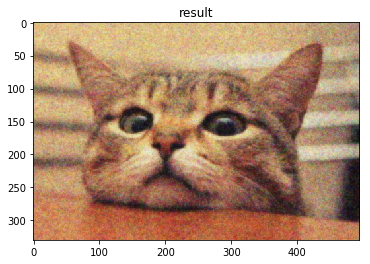

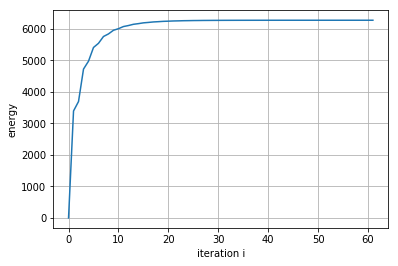

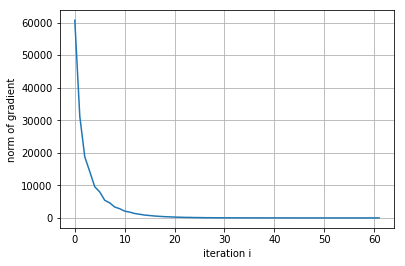

In [6]:
# visualization
plt.figure('result')
plt.imshow(np.reshape(u,(c, nx, ny)).T)
plt.title('result')
plt.show()
plt.figure('energy')
plt.plot(energy)
plt.ylabel('energy'), plt.xlabel('iteration i')
plt.grid()
plt.show()
plt.figure('norm of gradient')
plt.plot(norm_gradient)
plt.ylabel('norm of gradient'), plt.xlabel('iteration i')
plt.grid()
plt.show()

***